In [ ]:
%pip install ultralytics
%pip install opencv-python

In [6]:
import os
import cv2
import yaml
import kagglehub
import shutil
import pandas as pd
from ultralytics import YOLO

In [2]:
data = {
    "path": "C:/Users/timon/git/cvai-classisign/dataset",
    "train": "images/train",
    "val": "images/val",
    "nc": 1,
    "names": [
        'sign detected'
        ]
}

with open("data.yaml", "w") as file:
    yaml.dump(data, file, sort_keys=False)

In [3]:
# Download dataset
download_path = kagglehub.dataset_download("safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb")

# Paths
train_image_dir = os.path.join(download_path, "TrainIJCNN2013", "TrainIJCNN2013")
test_image_dir = os.path.join(download_path, "TestIJCNN2013", "TestIJCNN2013Download")
annotation_file = os.path.join(download_path, "gt.txt")
output_train_image_dir = "dataset/images/train"
output_test_image_dir = "dataset/images/test"
output_label_dir = "dataset/labels/train"
val_image_dir = "dataset/images/val"
val_label_dir = "dataset/labels/val"

# Create directories
os.makedirs(output_train_image_dir, exist_ok=True)
os.makedirs(output_test_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# Read annotations
with open(annotation_file, "r") as f:
    lines = f.readlines()

# Parse and convert each line
for line in lines:
    parts = line.strip().split(";")
    img_name, x1, y1, x2, y2, _ = parts  # Ignore class_id
    x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))

    img_path = os.path.join(train_image_dir, img_name)
    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue
    h, w = img.shape[:2]

    # YOLO format
    x_center = ((x1 + x2) / 2) / w
    y_center = ((y1 + y2) / 2) / h
    width = (x2 - x1) / w
    height = (y2 - y1) / h

    # Change extension to .jpg
    new_img_name = img_name.replace(".ppm", ".jpg")
    label_name = new_img_name.replace(".jpg", ".txt")

    label_path = os.path.join(output_label_dir, label_name)
    with open(label_path, "a") as label_file:
        label_file.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    out_img_path = os.path.join(output_train_image_dir, new_img_name)
    if not os.path.exists(out_img_path):
        cv2.imwrite(out_img_path, img)

# Move the last 60 label-image pairs to validation set
label_files = sorted([f for f in os.listdir(output_label_dir) if f.endswith(".txt")])
val_sample = label_files[-60:]

for label_file in val_sample:
    shutil.move(os.path.join(output_label_dir, label_file), os.path.join(val_label_dir, label_file))
    image_file = label_file.replace(".txt", ".jpg")
    src_img = os.path.join(output_train_image_dir, image_file)
    dst_img = os.path.join(val_image_dir, image_file)
    if os.path.exists(src_img):
        shutil.move(src_img, dst_img)

# Copy and convert test images to JPG
for img_name in os.listdir(test_image_dir):
    if img_name.endswith(".ppm"):
        img_path = os.path.join(test_image_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            new_img_name = img_name.replace(".ppm", ".jpg")
            out_img_path = os.path.join(output_test_image_dir, new_img_name)
            cv2.imwrite(out_img_path, img)

In [5]:
model = YOLO("yolov8n.pt")

results = model.train(data="data.yaml", epochs=150, imgsz=640)

Ultralytics 8.3.141  Python-3.12.10 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pret

train: Scanning C:\Users\timon\git\cvai-classisign\dataset\labels\train.cache... 446 images, 0 backgrounds, 0 corrupt: 100%|██████████| 446/446 [00:00<?, ?it/s]

train: C:\Users\timon\git\cvai-classisign\dataset\images\train\00340.jpg: 1 duplicate labels removed


val: Fast image access  (ping: 0.00.0 ms, read: 1745.3311.8 MB/s, size: 301.9 KB)


val: Scanning C:\Users\timon\git\cvai-classisign\dataset\labels\val.cache... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]


Plotting labels to runs\detect\train4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train4
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      2.55G      1.412      3.433     0.9542         54        640: 100%|██████████| 28/28 [00:03<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.58it/s]

                   all         60         92    0.00394      0.772    0.00894    0.00451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      2.55G      1.178      1.773     0.8728         33        640: 100%|██████████| 28/28 [00:02<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]

                   all         60         92    0.00272      0.533    0.00407    0.00249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      2.55G      1.153      1.462     0.8885         44        640: 100%|██████████| 28/28 [00:01<00:00, 14.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]

                   all         60         92     0.0729      0.114     0.0661     0.0423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      2.55G      1.096      1.289     0.8754         45        640: 100%|██████████| 28/28 [00:01<00:00, 15.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.62it/s]

                   all         60         92      0.927      0.695      0.811      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      2.55G      1.157       1.27      0.878         33        640: 100%|██████████| 28/28 [00:01<00:00, 14.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]

                   all         60         92       0.49      0.685      0.406       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      2.55G      1.113       1.11      0.869         44        640: 100%|██████████| 28/28 [00:01<00:00, 15.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]

                   all         60         92      0.954      0.739       0.86      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      2.55G      1.083     0.9771     0.8721         48        640: 100%|██████████| 28/28 [00:01<00:00, 15.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]

                   all         60         92      0.876      0.766      0.859      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      2.55G     0.9884     0.8897     0.8606         46        640: 100%|██████████| 28/28 [00:01<00:00, 14.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]

                   all         60         92      0.902      0.796      0.882      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      2.55G     0.9943     0.8169     0.8573         35        640: 100%|██████████| 28/28 [00:01<00:00, 15.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]

                   all         60         92       0.89      0.794      0.875      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      2.55G     0.9426     0.7631     0.8489         46        640: 100%|██████████| 28/28 [00:01<00:00, 14.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]

                   all         60         92       0.89      0.794      0.887      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      2.55G     0.9518      0.729     0.8455         52        640: 100%|██████████| 28/28 [00:01<00:00, 15.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]

                   all         60         92      0.908      0.772       0.88      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      2.55G     0.9141     0.6886     0.8425         57        640: 100%|██████████| 28/28 [00:01<00:00, 15.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]

                   all         60         92      0.915      0.822      0.904      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      2.55G     0.9585     0.6921     0.8408         38        640: 100%|██████████| 28/28 [00:01<00:00, 15.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]

                   all         60         92      0.896      0.842      0.912      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      2.55G     0.9116     0.6443     0.8362         48        640: 100%|██████████| 28/28 [00:01<00:00, 14.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]

                   all         60         92      0.885      0.804      0.893      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      2.55G     0.9448     0.6649     0.8408         36        640: 100%|██████████| 28/28 [00:01<00:00, 15.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.20it/s]

                   all         60         92        0.9      0.804      0.888      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      2.55G     0.9567     0.6564      0.853         43        640: 100%|██████████| 28/28 [00:01<00:00, 15.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]

                   all         60         92       0.96      0.772      0.899       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      2.55G     0.9122     0.6101     0.8392         47        640: 100%|██████████| 28/28 [00:01<00:00, 15.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]

                   all         60         92      0.937      0.802      0.893      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      2.55G     0.8883     0.5821      0.841         31        640: 100%|██████████| 28/28 [00:01<00:00, 14.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]

                   all         60         92      0.873      0.848      0.908      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      2.55G     0.9226     0.5866     0.8293         46        640: 100%|██████████| 28/28 [00:01<00:00, 14.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]

                   all         60         92      0.911      0.779      0.884      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      2.55G     0.8695     0.5989     0.8401         35        640: 100%|██████████| 28/28 [00:01<00:00, 15.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]

                   all         60         92      0.853      0.848      0.911      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      2.55G     0.8777     0.5617     0.8374         40        640: 100%|██████████| 28/28 [00:01<00:00, 15.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]

                   all         60         92      0.876      0.844      0.915      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      2.55G     0.8637      0.573     0.8261         42        640: 100%|██████████| 28/28 [00:01<00:00, 15.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]

                   all         60         92      0.894      0.823      0.906      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      2.55G     0.8734     0.5545     0.8298         37        640: 100%|██████████| 28/28 [00:01<00:00, 14.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]

                   all         60         92       0.89      0.815      0.895       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      2.55G     0.9086     0.5742     0.8327         35        640: 100%|██████████| 28/28 [00:01<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]

                   all         60         92      0.878      0.864      0.904       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      2.55G     0.8544     0.5361     0.8306         45        640: 100%|██████████| 28/28 [00:01<00:00, 15.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]

                   all         60         92      0.886      0.842      0.915      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      2.55G     0.8354     0.5474     0.8309         38        640: 100%|██████████| 28/28 [00:01<00:00, 15.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]

                   all         60         92      0.847      0.843      0.908      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      2.55G     0.8558     0.5418      0.824         43        640: 100%|██████████| 28/28 [00:01<00:00, 15.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]

                   all         60         92      0.937      0.783      0.912       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      2.55G     0.8321     0.5268     0.8279         52        640: 100%|██████████| 28/28 [00:01<00:00, 15.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]

                   all         60         92      0.872      0.837      0.896      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      2.55G     0.8399     0.5307     0.8299         39        640: 100%|██████████| 28/28 [00:01<00:00, 15.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]

                   all         60         92      0.905      0.831      0.907      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      2.55G     0.8756     0.5244      0.831         46        640: 100%|██████████| 28/28 [00:01<00:00, 15.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]

                   all         60         92      0.949      0.826      0.904      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      2.55G     0.8106      0.506     0.8287         39        640: 100%|██████████| 28/28 [00:01<00:00, 15.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]

                   all         60         92       0.97      0.837      0.912      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      2.55G     0.8081     0.5174     0.8228         35        640: 100%|██████████| 28/28 [00:01<00:00, 14.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]

                   all         60         92       0.96       0.87      0.925       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      2.55G     0.7902     0.4993     0.8174         54        640: 100%|██████████| 28/28 [00:01<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]

                   all         60         92      0.909       0.88      0.926      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      2.55G        0.8     0.4957     0.8127         40        640: 100%|██████████| 28/28 [00:01<00:00, 14.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.03it/s]

                   all         60         92      0.938      0.848      0.918      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      2.55G     0.7985      0.487     0.8184         40        640: 100%|██████████| 28/28 [00:01<00:00, 15.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]

                   all         60         92      0.953      0.837      0.925       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      2.55G     0.7627     0.4856     0.8163         42        640: 100%|██████████| 28/28 [00:01<00:00, 15.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]

                   all         60         92      0.894      0.921      0.937      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      2.55G     0.7907     0.4932     0.8249         41        640: 100%|██████████| 28/28 [00:01<00:00, 14.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]

                   all         60         92       0.92      0.877      0.928      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      2.55G     0.7985     0.4831     0.8249         29        640: 100%|██████████| 28/28 [00:01<00:00, 14.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]

                   all         60         92      0.963      0.793       0.93       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      2.55G     0.7842     0.4803     0.8291         45        640: 100%|██████████| 28/28 [00:01<00:00, 15.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]

                   all         60         92      0.926      0.819       0.92      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      2.55G     0.7723     0.4724     0.8181         28        640: 100%|██████████| 28/28 [00:01<00:00, 15.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]

                   all         60         92       0.92       0.88      0.926      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      2.55G     0.7673     0.4758     0.8078         37        640: 100%|██████████| 28/28 [00:01<00:00, 15.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]

                   all         60         92      0.949      0.837       0.92      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      2.55G     0.7656     0.4744     0.8049         39        640: 100%|██████████| 28/28 [00:01<00:00, 15.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]

                   all         60         92      0.872      0.891      0.926      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      2.55G     0.7645     0.4654     0.8202         36        640: 100%|██████████| 28/28 [00:01<00:00, 15.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]

                   all         60         92      0.931      0.874      0.929      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      2.55G     0.7673     0.4576     0.8099         45        640: 100%|██████████| 28/28 [00:01<00:00, 14.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]

                   all         60         92      0.906      0.935      0.947      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.55G     0.7481     0.4645     0.8175         39        640: 100%|██████████| 28/28 [00:01<00:00, 15.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]

                   all         60         92       0.92      0.871      0.929      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      2.55G      0.754     0.4591     0.8096         33        640: 100%|██████████| 28/28 [00:01<00:00, 15.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]

                   all         60         92      0.898      0.848       0.94      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      2.55G     0.7553     0.4588     0.8177         61        640: 100%|██████████| 28/28 [00:01<00:00, 14.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]

                   all         60         92       0.94      0.815      0.947      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      2.55G     0.7617     0.4632     0.8152         42        640: 100%|██████████| 28/28 [00:01<00:00, 15.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]

                   all         60         92      0.938      0.837      0.942      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.55G     0.7513     0.4542     0.8191         33        640: 100%|██████████| 28/28 [00:01<00:00, 15.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]

                   all         60         92       0.94      0.852      0.936      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.55G     0.7255     0.4406     0.8076         44        640: 100%|██████████| 28/28 [00:01<00:00, 14.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]

                   all         60         92      0.899      0.871      0.932      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.55G     0.7082     0.4388     0.8157         29        640: 100%|██████████| 28/28 [00:01<00:00, 14.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]

                   all         60         92      0.951      0.843      0.939      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.55G     0.7586     0.4563     0.8107         45        640: 100%|██████████| 28/28 [00:01<00:00, 14.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]

                   all         60         92       0.95      0.793       0.93      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.55G     0.7298     0.4385      0.819         28        640: 100%|██████████| 28/28 [00:01<00:00, 14.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]

                   all         60         92      0.916      0.859      0.931      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.55G     0.7427     0.4469     0.8098         50        640: 100%|██████████| 28/28 [00:01<00:00, 15.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]

                   all         60         92      0.933      0.848      0.934      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.55G     0.7406     0.4466     0.8079         48        640: 100%|██████████| 28/28 [00:01<00:00, 15.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]

                   all         60         92      0.953      0.815      0.928       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      2.55G       0.73     0.4328      0.813         40        640: 100%|██████████| 28/28 [00:01<00:00, 15.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]

                   all         60         92       0.95      0.831      0.931      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.55G     0.7004     0.4213     0.8065         47        640: 100%|██████████| 28/28 [00:01<00:00, 15.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]

                   all         60         92      0.912      0.837      0.926      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.55G      0.736     0.4334     0.8067         33        640: 100%|██████████| 28/28 [00:01<00:00, 14.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]

                   all         60         92      0.925      0.848      0.929      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.55G      0.691     0.4165      0.808         37        640: 100%|██████████| 28/28 [00:01<00:00, 14.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.83it/s]

                   all         60         92      0.938       0.88      0.942      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.55G      0.708     0.4315     0.8087         45        640: 100%|██████████| 28/28 [00:01<00:00, 15.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]

                   all         60         92        0.9      0.859      0.939      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.55G     0.6708     0.4251     0.8055         42        640: 100%|██████████| 28/28 [00:01<00:00, 14.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]

                   all         60         92      0.928      0.843      0.931      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      2.55G     0.6806     0.4148     0.8022         40        640: 100%|██████████| 28/28 [00:01<00:00, 14.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]

                   all         60         92      0.951      0.848       0.94      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      2.55G     0.6837     0.4171     0.8059         44        640: 100%|██████████| 28/28 [00:01<00:00, 14.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]

                   all         60         92      0.941      0.826      0.925      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      2.55G      0.687     0.4254     0.8037         31        640: 100%|██████████| 28/28 [00:01<00:00, 15.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]

                   all         60         92       0.88       0.88      0.929      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.55G     0.7137     0.4324     0.8011         39        640: 100%|██████████| 28/28 [00:01<00:00, 14.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]

                   all         60         92      0.948      0.848      0.927      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.55G     0.6948     0.4192     0.7993         41        640: 100%|██████████| 28/28 [00:01<00:00, 14.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.51it/s]

                   all         60         92       0.94      0.853      0.928      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.55G     0.6762     0.4025     0.8057         37        640: 100%|██████████| 28/28 [00:01<00:00, 14.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]

                   all         60         92      0.898      0.865      0.945      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.55G     0.6679     0.4094     0.8139         43        640: 100%|██████████| 28/28 [00:01<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]

                   all         60         92      0.898      0.865      0.931      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.55G     0.6984     0.4138     0.8006         41        640: 100%|██████████| 28/28 [00:01<00:00, 15.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]

                   all         60         92       0.92       0.87      0.938      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.55G     0.6942     0.4106      0.802         28        640: 100%|██████████| 28/28 [00:01<00:00, 15.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]

                   all         60         92      0.921      0.859      0.937      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.55G     0.6716     0.3984      0.801         27        640: 100%|██████████| 28/28 [00:01<00:00, 14.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.83it/s]

                   all         60         92      0.951      0.859      0.946      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.55G     0.6937     0.4079     0.8166         44        640: 100%|██████████| 28/28 [00:01<00:00, 15.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]

                   all         60         92      0.974      0.824      0.938      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.55G     0.6521     0.3983     0.8064         46        640: 100%|██████████| 28/28 [00:01<00:00, 14.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]

                   all         60         92      0.974      0.826      0.935      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.55G     0.6604      0.383     0.8049         28        640: 100%|██████████| 28/28 [00:01<00:00, 15.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]

                   all         60         92      0.951      0.859       0.94      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.55G     0.7022     0.4135     0.7988         44        640: 100%|██████████| 28/28 [00:01<00:00, 15.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]

                   all         60         92      0.951      0.839      0.939       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.55G     0.6735     0.3967     0.8065         47        640: 100%|██████████| 28/28 [00:01<00:00, 15.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]

                   all         60         92       0.96      0.837      0.928      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.55G     0.6662     0.3846     0.8023         34        640: 100%|██████████| 28/28 [00:01<00:00, 14.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]

                   all         60         92       0.93      0.848      0.945      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.55G     0.6441     0.3813     0.8011         26        640: 100%|██████████| 28/28 [00:01<00:00, 15.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]

                   all         60         92      0.929      0.853      0.939       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.55G     0.6505     0.3851     0.7896         36        640: 100%|██████████| 28/28 [00:01<00:00, 15.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]

                   all         60         92       0.94      0.846      0.937      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.55G     0.6782     0.3937     0.8074         59        640: 100%|██████████| 28/28 [00:01<00:00, 15.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]

                   all         60         92      0.919      0.859      0.938      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.55G       0.66     0.3812     0.7983         34        640: 100%|██████████| 28/28 [00:01<00:00, 15.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]

                   all         60         92      0.912      0.891      0.926      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.55G     0.6741     0.3995     0.8019         42        640: 100%|██████████| 28/28 [00:01<00:00, 15.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]

                   all         60         92      0.938       0.88      0.929      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.55G     0.6455      0.381     0.7988         50        640: 100%|██████████| 28/28 [00:01<00:00, 15.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]

                   all         60         92      0.952       0.86       0.94      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.55G     0.6742     0.3939     0.8069         39        640: 100%|██████████| 28/28 [00:01<00:00, 15.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]

                   all         60         92      0.931       0.87      0.944      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.55G     0.6802     0.3841     0.8019         54        640: 100%|██████████| 28/28 [00:01<00:00, 15.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]

                   all         60         92      0.939      0.902      0.936      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.55G     0.6515     0.3752     0.8025         43        640: 100%|██████████| 28/28 [00:01<00:00, 15.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]

                   all         60         92      0.941       0.87      0.949      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.55G     0.6364     0.3645     0.8012         48        640: 100%|██████████| 28/28 [00:01<00:00, 14.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]

                   all         60         92      0.919       0.88      0.913      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.55G      0.627     0.3723     0.7954         29        640: 100%|██████████| 28/28 [00:01<00:00, 15.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]

                   all         60         92      0.951      0.848      0.916       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.55G      0.655     0.3725     0.8001         37        640: 100%|██████████| 28/28 [00:01<00:00, 15.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]

                   all         60         92      0.882      0.891      0.936      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.55G     0.6755     0.3834     0.7993         32        640: 100%|██████████| 28/28 [00:01<00:00, 15.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]

                   all         60         92      0.926      0.859      0.937      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.55G     0.6461     0.3732     0.7948         49        640: 100%|██████████| 28/28 [00:01<00:00, 15.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]

                   all         60         92      0.939       0.87      0.945      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.55G     0.6363     0.3667     0.7975         41        640: 100%|██████████| 28/28 [00:01<00:00, 14.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]

                   all         60         92      0.944      0.815      0.929      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.55G     0.6173     0.3619     0.8003         52        640: 100%|██████████| 28/28 [00:01<00:00, 15.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]

                   all         60         92      0.941      0.866      0.939      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.55G     0.6172     0.3569     0.7967         48        640: 100%|██████████| 28/28 [00:01<00:00, 15.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]

                   all         60         92      0.897       0.88      0.921      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.55G     0.5972     0.3587     0.7981         30        640: 100%|██████████| 28/28 [00:01<00:00, 15.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]

                   all         60         92      0.916       0.88      0.936      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.55G     0.6603     0.3786     0.8025         38        640: 100%|██████████| 28/28 [00:01<00:00, 15.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]

                   all         60         92      0.909      0.891      0.936      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.55G     0.6552     0.3785     0.7955         37        640: 100%|██████████| 28/28 [00:01<00:00, 15.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]

                   all         60         92       0.92      0.902      0.949       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.55G     0.6514     0.3726     0.8096         46        640: 100%|██████████| 28/28 [00:01<00:00, 15.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]

                   all         60         92      0.943      0.898      0.942      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.55G     0.6343     0.3603     0.8015         43        640: 100%|██████████| 28/28 [00:01<00:00, 15.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]

                   all         60         92      0.905      0.891       0.94      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.55G     0.6261     0.3644     0.7987         40        640: 100%|██████████| 28/28 [00:01<00:00, 15.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]

                   all         60         92       0.91      0.879      0.929      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.55G     0.6146     0.3561     0.7895         52        640: 100%|██████████| 28/28 [00:01<00:00, 15.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]

                   all         60         92      0.892      0.897      0.936      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.55G     0.6091     0.3565     0.7981         36        640: 100%|██████████| 28/28 [00:01<00:00, 15.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]

                   all         60         92      0.912      0.906      0.949      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.55G     0.6038     0.3491     0.7956         30        640: 100%|██████████| 28/28 [00:01<00:00, 15.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]

                   all         60         92      0.921      0.883      0.944      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.55G      0.613     0.3508     0.8029         38        640: 100%|██████████| 28/28 [00:01<00:00, 15.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]

                   all         60         92      0.912      0.902      0.935      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.55G     0.5934      0.348     0.7956         52        640: 100%|██████████| 28/28 [00:01<00:00, 15.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]

                   all         60         92      0.953      0.878      0.946      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.55G     0.5883     0.3431     0.7961         35        640: 100%|██████████| 28/28 [00:01<00:00, 14.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]

                   all         60         92      0.914      0.935      0.953      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.55G     0.5945      0.343     0.7934         39        640: 100%|██████████| 28/28 [00:01<00:00, 14.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]

                   all         60         92      0.923      0.912      0.955      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.55G     0.6118     0.3576     0.7947         44        640: 100%|██████████| 28/28 [00:01<00:00, 15.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]

                   all         60         92      0.923      0.907      0.949      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.55G     0.6055     0.3552     0.8011         58        640: 100%|██████████| 28/28 [00:01<00:00, 15.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]

                   all         60         92      0.878      0.946       0.95      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.55G     0.5925      0.345     0.7929         30        640: 100%|██████████| 28/28 [00:01<00:00, 15.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]

                   all         60         92       0.91      0.924      0.952      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.55G     0.5846     0.3438     0.8037         30        640: 100%|██████████| 28/28 [00:01<00:00, 14.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]

                   all         60         92       0.95      0.823      0.925      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.55G     0.5851     0.3419     0.7968         46        640: 100%|██████████| 28/28 [00:01<00:00, 15.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]

                   all         60         92      0.921      0.913      0.949      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.55G     0.5489     0.3295     0.7881         40        640: 100%|██████████| 28/28 [00:01<00:00, 15.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]

                   all         60         92       0.94      0.902      0.936       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.55G     0.5474     0.3207     0.7886         43        640: 100%|██████████| 28/28 [00:01<00:00, 14.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]

                   all         60         92      0.931      0.913       0.94      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.55G     0.5809     0.3337     0.7918         26        640: 100%|██████████| 28/28 [00:01<00:00, 15.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]

                   all         60         92      0.944      0.921      0.953      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.55G     0.5777      0.335     0.7949         48        640: 100%|██████████| 28/28 [00:01<00:00, 15.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]

                   all         60         92      0.915      0.933       0.95      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.55G     0.5755     0.3339     0.7838         44        640: 100%|██████████| 28/28 [00:01<00:00, 14.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]

                   all         60         92      0.929      0.913      0.947      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.55G     0.5607     0.3204     0.7817         42        640: 100%|██████████| 28/28 [00:01<00:00, 15.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]

                   all         60         92       0.94      0.891      0.944      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.55G     0.5685     0.3258     0.7973         52        640: 100%|██████████| 28/28 [00:01<00:00, 14.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]

                   all         60         92      0.916      0.902      0.941      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.55G     0.5551     0.3254     0.7882         45        640: 100%|██████████| 28/28 [00:01<00:00, 14.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]

                   all         60         92      0.925      0.891       0.93      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.55G     0.5447     0.3185     0.7866         35        640: 100%|██████████| 28/28 [00:01<00:00, 14.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]

                   all         60         92      0.942      0.878      0.934      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.55G     0.5443      0.317     0.7951         54        640: 100%|██████████| 28/28 [00:01<00:00, 15.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]

                   all         60         92      0.913      0.913      0.952      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.55G     0.5426     0.3158     0.7896         37        640: 100%|██████████| 28/28 [00:01<00:00, 15.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]

                   all         60         92      0.933      0.913      0.949       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.55G      0.536     0.3145     0.7905         34        640: 100%|██████████| 28/28 [00:01<00:00, 14.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]

                   all         60         92      0.932      0.892      0.939      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.55G     0.5527      0.321      0.789         41        640: 100%|██████████| 28/28 [00:01<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]

                   all         60         92      0.941      0.868      0.934      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.55G     0.5429     0.3183     0.7913         34        640: 100%|██████████| 28/28 [00:01<00:00, 15.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]

                   all         60         92      0.963      0.859      0.948      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.55G     0.5407     0.3132     0.7865         39        640: 100%|██████████| 28/28 [00:01<00:00, 15.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]

                   all         60         92      0.926      0.902      0.945      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.55G     0.5367     0.3098     0.7814         58        640: 100%|██████████| 28/28 [00:01<00:00, 15.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]

                   all         60         92      0.942      0.902      0.944      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.55G      0.559     0.3214     0.7932         32        640: 100%|██████████| 28/28 [00:01<00:00, 14.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]

                   all         60         92       0.95      0.902      0.942       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.55G     0.5411     0.3141     0.7757         39        640: 100%|██████████| 28/28 [00:01<00:00, 15.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]

                   all         60         92      0.954      0.893      0.945      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.55G     0.5418     0.3087     0.7919         37        640: 100%|██████████| 28/28 [00:01<00:00, 15.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]

                   all         60         92      0.942      0.902      0.949      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.55G     0.5331     0.3062     0.7875         37        640: 100%|██████████| 28/28 [00:01<00:00, 15.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.87it/s]

                   all         60         92      0.914      0.924      0.951      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.55G     0.5253     0.3071     0.7942         30        640: 100%|██████████| 28/28 [00:01<00:00, 15.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]

                   all         60         92      0.931      0.913      0.945      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.55G     0.5394     0.3017     0.7874         43        640: 100%|██████████| 28/28 [00:01<00:00, 15.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]

                   all         60         92      0.923      0.916      0.943       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.55G     0.4997     0.2907     0.7823         37        640: 100%|██████████| 28/28 [00:01<00:00, 15.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]

                   all         60         92      0.924      0.921      0.942      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.55G     0.5209     0.3015     0.7859         37        640: 100%|██████████| 28/28 [00:02<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]

                   all         60         92      0.944      0.911      0.945      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.55G     0.5381     0.3065     0.7833         48        640: 100%|██████████| 28/28 [00:01<00:00, 15.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]

                   all         60         92      0.953       0.89      0.936       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.55G     0.5291     0.3064      0.787         39        640: 100%|██████████| 28/28 [00:01<00:00, 15.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]

                   all         60         92      0.941      0.891      0.937      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.55G     0.5257      0.298     0.7853         49        640: 100%|██████████| 28/28 [00:01<00:00, 15.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]

                   all         60         92      0.934      0.891      0.935      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.55G     0.5333     0.3066     0.7828         36        640: 100%|██████████| 28/28 [00:01<00:00, 15.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]

                   all         60         92      0.926      0.913      0.943      0.778


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.55G     0.4942     0.2952     0.7759         20        640: 100%|██████████| 28/28 [00:02<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]

                   all         60         92      0.942      0.889      0.942      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.55G     0.5078     0.3021     0.7827         22        640: 100%|██████████| 28/28 [00:01<00:00, 15.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]

                   all         60         92      0.932      0.902      0.945      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.55G     0.4931     0.2859     0.7831         18        640: 100%|██████████| 28/28 [00:01<00:00, 15.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]

                   all         60         92      0.921      0.902      0.943      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.55G     0.4993     0.2805     0.7738         26        640: 100%|██████████| 28/28 [00:01<00:00, 15.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]

                   all         60         92        0.9      0.913      0.946      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.55G      0.498     0.2839     0.7878         26        640: 100%|██████████| 28/28 [00:01<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]

                   all         60         92      0.943      0.899      0.951      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.55G     0.4768     0.2774     0.7888         23        640: 100%|██████████| 28/28 [00:01<00:00, 15.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]

                   all         60         92      0.931      0.902      0.951      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.55G     0.4905     0.2767      0.791         26        640: 100%|██████████| 28/28 [00:01<00:00, 14.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]

                   all         60         92      0.929      0.902      0.948      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.55G     0.4839     0.2819     0.7862         30        640: 100%|██████████| 28/28 [00:01<00:00, 15.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]

                   all         60         92      0.919      0.913      0.948      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.55G     0.4717     0.2765     0.7815         24        640: 100%|██████████| 28/28 [00:01<00:00, 14.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]

                   all         60         92      0.916      0.902      0.948      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.55G      0.478     0.2715     0.7765         18        640: 100%|██████████| 28/28 [00:01<00:00, 14.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]

                   all         60         92      0.923      0.908      0.948      0.777



150 epochs completed in 0.097 hours.
Optimizer stripped from runs\detect\train4\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train4\weights\best.pt, 6.2MB

Validating runs\detect\train4\weights\best.pt...
Ultralytics 8.3.141  Python-3.12.10 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.34it/s]


                   all         60         92      0.963      0.859      0.948      0.792
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\train4


In [7]:
model = YOLO("runs/detect/train4/weights/best.pt")  # load a custom model

# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map  # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps  # a list contains map50-95 of each category

Ultralytics 8.3.141  Python-3.12.10 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 68.715.3 MB/s, size: 280.3 KB)


val: Scanning C:\Users\timon\git\cvai-classisign\dataset\labels\val.cache... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


                   all         60         92      0.963      0.859      0.949      0.793
Speed: 1.0ms preprocess, 2.3ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs\detect\val6


array([    0.79342])

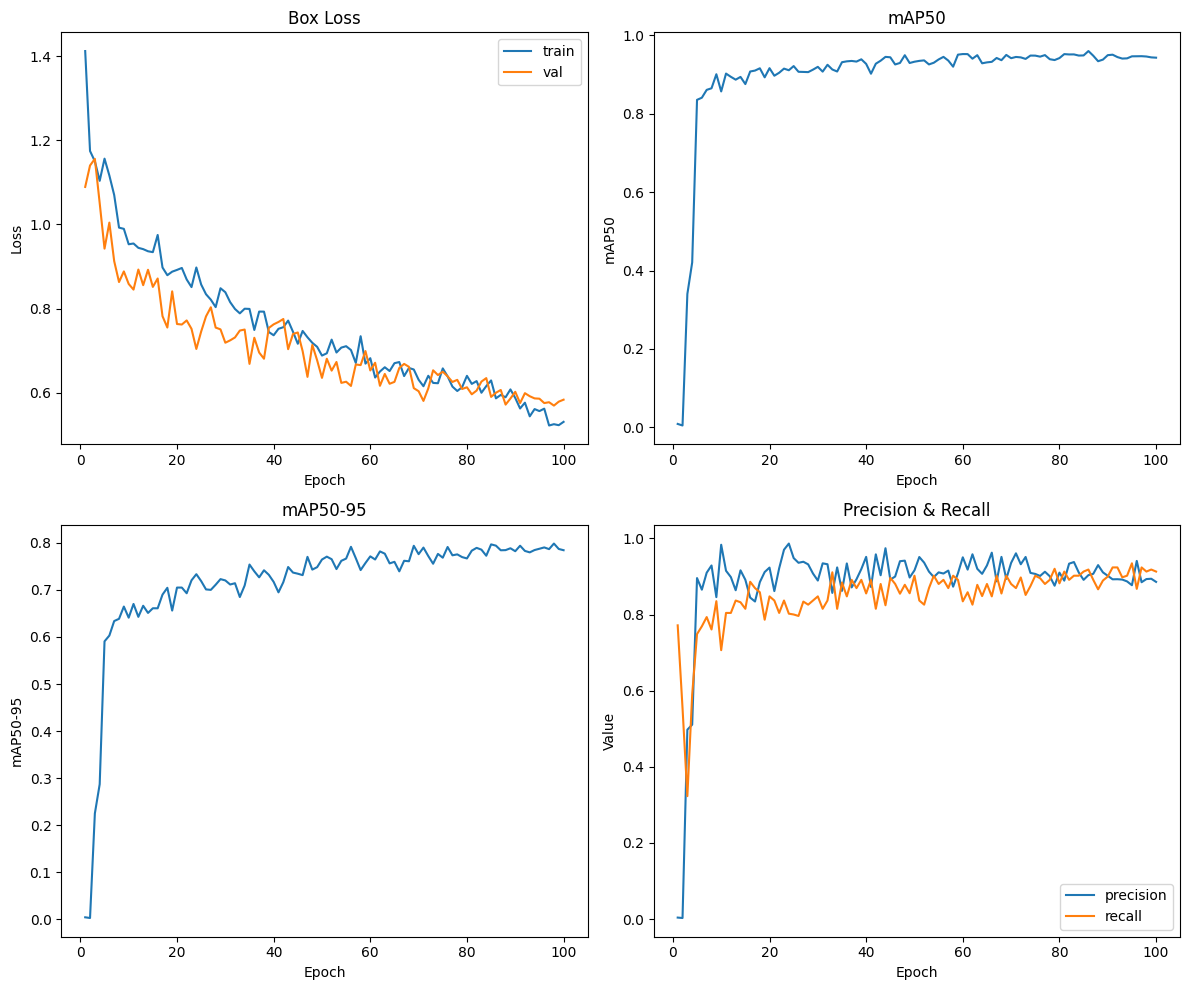

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the results CSV file that was generated during training
results_file = "runs/detect/train3/results.csv"
data = pd.read_csv(results_file)

# Create a figure with multiple subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot training and validation loss
ax[0, 0].plot(data['epoch'], data['train/box_loss'], label='train')
ax[0, 0].plot(data['epoch'], data['val/box_loss'], label='val')
ax[0, 0].set_title('Box Loss')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend()

# Plot mAP50
ax[0, 1].plot(data['epoch'], data['metrics/mAP50(B)'])
ax[0, 1].set_title('mAP50')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('mAP50')

# Plot mAP50-95
ax[1, 0].plot(data['epoch'], data['metrics/mAP50-95(B)'])
ax[1, 0].set_title('mAP50-95')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('mAP50-95')

# Plot precision and recall
ax[1, 1].plot(data['epoch'], data['metrics/precision(B)'], label='precision')
ax[1, 1].plot(data['epoch'], data['metrics/recall(B)'], label='recall')
ax[1, 1].set_title('Precision & Recall')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Value')
ax[1, 1].legend()

plt.tight_layout()
plt.savefig('yolov8_training_metrics.png')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the results CSV file that was generated during YOLOv8 training
results_file = "runs/detect/train3/results.csv"
data = pd.read_csv(results_file)

# Extract number of epochs from the data
epochs = len(data)
epoch_range = list(range(1, epochs + 1))

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot 1: Training and Validation Loss
ax1.plot(data['epoch'], data['train/box_loss'], 'b-', label='Training Box Loss')
ax1.plot(data['epoch'], data['val/box_loss'], 'r-', label='Validation Box Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot 2: mAP50 and mAP50-95 in the same chart
ax2.plot(data['epoch'], data['metrics/mAP50(B)'], 'g-', label='mAP50')
ax2.plot(data['epoch'], data['metrics/mAP50-95(B)'], 'm-', label='mAP50-95')
ax2.set_title('YOLO Detection Performance')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('mAP')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('yolo_training_history.png')
plt.show()

<Figure size 1000x1200 with 2 Axes>

: 

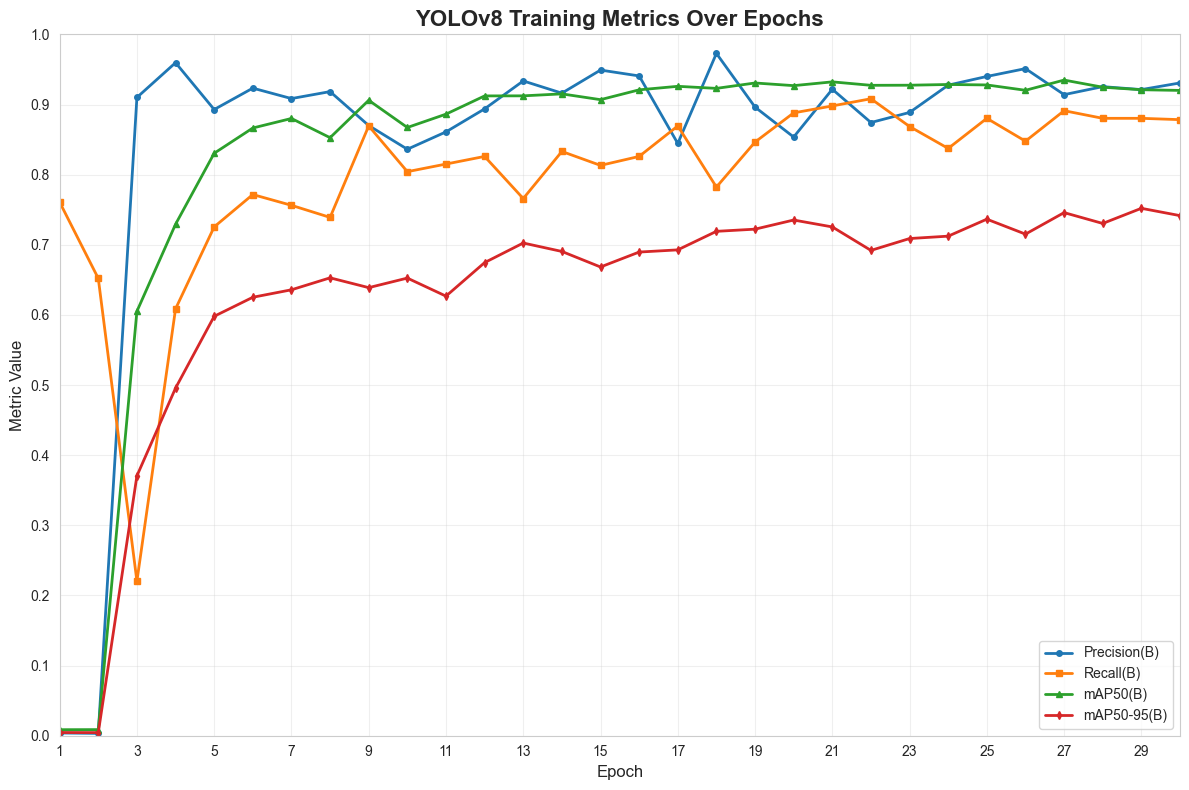

Epoch-wise performance metrics:
 epoch  metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  metrics/mAP50-95(B)
     1               0.00389            0.76087           0.00859              0.00453
     2               0.00333            0.65217           0.00871              0.00446
     3               0.91018            0.22038           0.60525              0.37057
     4               0.95975            0.60870           0.72938              0.49571
     5               0.89298            0.72561           0.83060              0.59811
     6               0.92348            0.77174           0.86663              0.62525
     7               0.90860            0.75638           0.88022              0.63591
     8               0.91853            0.73913           0.85282              0.65296
     9               0.87015            0.86957           0.90616              0.63898
    10               0.83633            0.80435           0.86735              0.65260
    11     

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the results CSV file
df = pd.read_csv("runs/detect/train/results.csv")

# Ensure we have data for all 30 epochs
df_epochs = df[df['epoch'] <= 30].copy()

# Set up the plot style
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create the plot with multiple metrics
plt.plot(df_epochs['epoch'], df_epochs['metrics/precision(B)'], marker='o', markersize=4, linewidth=2, label='Precision(B)')
plt.plot(df_epochs['epoch'], df_epochs['metrics/recall(B)'], marker='s', markersize=4, linewidth=2, label='Recall(B)')
plt.plot(df_epochs['epoch'], df_epochs['metrics/mAP50(B)'], marker='^', markersize=4, linewidth=2, label='mAP50(B)')
plt.plot(df_epochs['epoch'], df_epochs['metrics/mAP50-95(B)'], marker='d', markersize=4, linewidth=2, label='mAP50-95(B)')

# Customize the plot
plt.title('YOLOv8 Training Metrics Over Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xlim(1, 30)
plt.ylim(0, 1.0)
plt.xticks(range(1, 31, 2))  # Show every 2nd epoch on x-axis
plt.yticks([i/10 for i in range(0, 11, 1)])  # 0 to 1.0 by 0.1 steps
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=10)

# Save the figure with high DPI
plt.tight_layout()
plt.savefig('yolov8_training_metrics.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Print a table of the metrics for each epoch
print("Epoch-wise performance metrics:")
print(df_epochs[['epoch', 'metrics/precision(B)', 'metrics/recall(B)', 
                'metrics/mAP50(B)', 'metrics/mAP50-95(B)']].to_string(index=False))

# Print the best metrics
print("\nBest metrics:")
print(f"Best Precision: {df_epochs.loc[best_precision_idx, 'metrics/precision(B)']:.4f} (Epoch {df_epochs.loc[best_precision_idx, 'epoch']:.0f})")
print(f"Best Recall: {df_epochs.loc[best_recall_idx, 'metrics/recall(B)']:.4f} (Epoch {df_epochs.loc[best_recall_idx, 'epoch']:.0f})")
print(f"Best mAP50: {df_epochs.loc[best_map50_idx, 'metrics/mAP50(B)']:.4f} (Epoch {df_epochs.loc[best_map50_idx, 'epoch']:.0f})")
print(f"Best mAP50-95: {df_epochs.loc[best_map5095_idx, 'metrics/mAP50-95(B)']:.4f} (Epoch {df_epochs.loc[best_map5095_idx, 'epoch']:.0f})")

In [6]:
df = pd.read_csv("runs/detect/train/results.csv")

# Find the row with the best (max) metrics/mAP50-95(B)
best_row = df.loc[df["metrics/mAP50-95(B)"].idxmax()]

# Select and print the relevant metrics from that row
print(best_row[["epoch", "metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)"]])

In [7]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=dataset/images/test save_txt=True conf=0.6

In [8]:
# Define paths
pred_label_dir = "runs/detect/predict/labels"  # Change if different
test_image_dir = "dataset/images/test"         # Or wherever your test images are
output_crop_dir = "runs/detect/predict/crops"  # Directory to save cropped images

os.makedirs(output_crop_dir, exist_ok=True)

# Loop over all predicted label files
for label_file in os.listdir(pred_label_dir):
    if not label_file.endswith(".txt"):
        continue

    image_name = label_file.replace(".txt", ".jpg")  # Assuming YOLO used .jpg images
    image_path = os.path.join(test_image_dir, image_name)
    if not os.path.exists(image_path):
        continue

    img = cv2.imread(image_path)
    if img is None:
        continue
    h, w = img.shape[:2]

    with open(os.path.join(pred_label_dir, label_file), "r") as f:
        lines = f.readlines()

    # Save each detection as a cropped image
    for i, line in enumerate(lines):
        parts = line.strip().split()
        if len(parts) != 5:
            continue
        _, x_center, y_center, width, height = map(float, parts)

        # Convert from YOLO format to pixel coordinates
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)

        # Ensure coordinates are within bounds
        x1, y1 = max(x1, 0), max(y1, 0)
        x2, y2 = min(x2, w - 1), min(y2, h - 1)

        cropped = img[y1:y2, x1:x2]
        crop_name = f"{image_name.replace('.jpg', '')}_pred_{i+1}.jpg"
        cv2.imwrite(os.path.join(output_crop_dir, crop_name), cropped)